In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Define the new directory path
new_directory = '/content/drive/MyDrive/Colab Notebooks'

# Change the current working directory to the new one
os.chdir(new_directory)

# Verify the change by printing the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


In [6]:
# Create temporary directories for train and test images
train_dir = "Data/train"
test_dir = "Data/test"
dev_dir = "Data/dev"

# Define the labels
labels = os.listdir(train_dir)
No_classes = len(labels)

# Definitions
img_width, img_height = 128, 128
batch_size = 32
No_epochs= 30

In [7]:
# Define image data generator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    seed= 42)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

dev_generator = datagen.flow_from_directory(
    dev_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5558 images belonging to 11 classes.
Found 687 images belonging to 11 classes.
Found 618 images belonging to 11 classes.


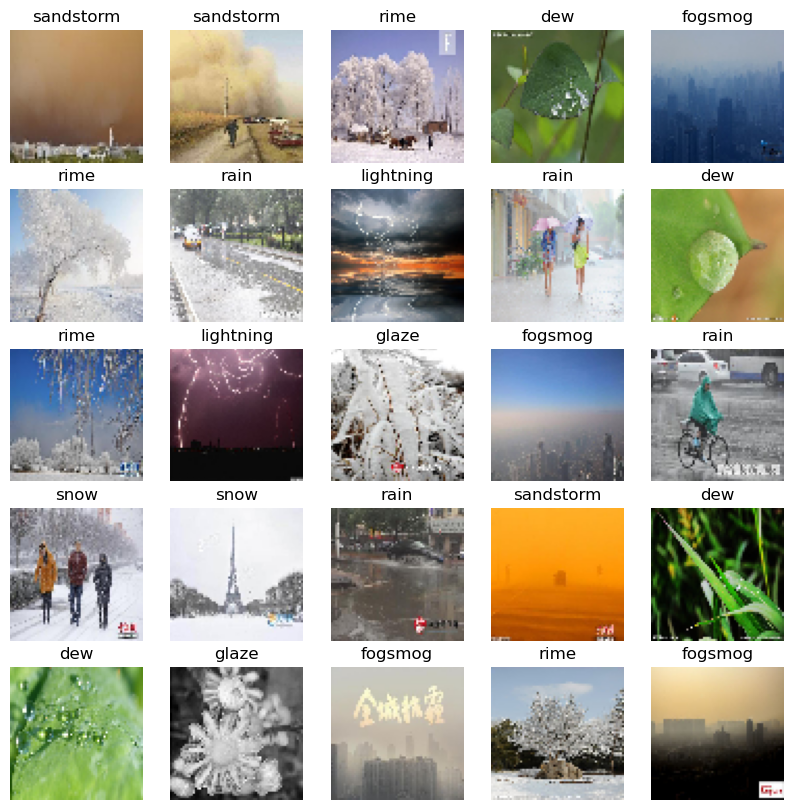

In [ ]:
# Get a batch of images from the generator
sample_images, sample_labels = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"{labels[np.argmax(sample_labels[i])]}")
    plt.axis('off')
plt.show()

In [8]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    # Set device for TensorFlow operations
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
else:
    print('GPU is not available')

GPU is available


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [12]:
# Define the input layer
input_layer = tf.keras.Input(shape=(img_width, img_height, 3))

augmen_layer = data_augmentation(input_layer)

# Base convolutional block
conv0 = Conv2D(16, (3, 3), kernel_regularizer=regularizers.l2(0.001))(augmen_layer)
conv0 = BatchNormalization()(conv0)
conv0 = Activation('relu')(conv0)
pool0 = MaxPooling2D((2, 2))(conv0)

# First convolutional block
conv1 = Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001))(pool0)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)

conv2 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
# skip connection
conv2 = Add()([conv2, conv1])
pool1 = MaxPooling2D((2, 2))(conv2)

# Second convolutional block
conv3 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(pool1)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)

conv4 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)

# skip connection
conv4 = Add()([conv4, conv3])
pool2 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(pool2)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)

conv6 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

# skip connection
conv6 = Add()([conv5, conv6])
pool3 = MaxPooling2D((2, 2))(conv6)

# Flatten and dense layers
flatten = Flatten()(pool3)
dense1 = Dense(256, activation='relu')(flatten)
dense1 = Dropout(0.15)(dense1)
output_layer = Dense(No_classes, activation='softmax')(dense1)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 126, 126, 16)         448       ['sequential[2][0]']          
                                                                                                  
 batch_normalization_11 (Ba  (None, 126, 126, 16)         64        ['conv2d_11[0][0]']           
 tchNormalization)                                                                          

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
with tf.device('/GPU:0'):
  history = model.fit(train_generator, validation_data=dev_generator, epochs=No_epochs, batch_size=batch_size)

Epoch 1/30
174/174 [==============================] - 1984s 11s/step - loss: 2.1932 - accuracy: 0.4563 - val_loss: 5.2246 - val_accuracy: 0.1375
Epoch 2/30
174/174 [==============================] - 40s 227ms/step - loss: 1.7186 - accuracy: 0.5410 - val_loss: 1.9810 - val_accuracy: 0.4612
Epoch 3/30
174/174 [==============================] - 39s 222ms/step - loss: 1.5696 - accuracy: 0.5675 - val_loss: 1.4965 - val_accuracy: 0.6165
Epoch 4/30
174/174 [==============================] - 39s 223ms/step - loss: 1.5016 - accuracy: 0.5882 - val_loss: 1.4610 - val_accuracy: 0.6278
Epoch 5/30
174/174 [==============================] - 38s 216ms/step - loss: 1.3939 - accuracy: 0.6173 - val_loss: 1.5148 - val_accuracy: 0.5502
Epoch 6/30
174/174 [==============================] - 38s 216ms/step - loss: 1.3394 - accuracy: 0.6281 - val_loss: 1.8750 - val_accuracy: 0.4595
Epoch 7/30
174/174 [==============================] - 38s 217ms/step - loss: 1.2797 - accuracy: 0.6385 - val_loss: 1.3634 - val_ac

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, batch_size=batch_size)
print(f"Test accuracy: {accuracy}")

22/22 [==============================] - 228s 11s/step - loss: 1.1301 - accuracy: 0.6652
Test accuracy: 0.6652110815048218


In [17]:
# Make predictions
y_pred = model.predict(test_generator, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)

22/22 [==============================] - 4s 161ms/step


In [18]:
# Calculate F1 score
f1 = f1_score(test_generator.labels, y_pred_classes, average='micro')
print(f"F1 score: {f1}")

F1 score: 0.6652110625909753


In [19]:
# Calculate F1 score
Report = classification_report(test_generator.labels, y_pred_classes)
print(Report)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        70
           1       0.93      0.51      0.66        85
           2       0.41      0.69      0.52        48
           3       0.43      0.41      0.42        64
           4       0.85      0.37      0.52        59
           5       0.94      0.79      0.86        38
           6       0.56      0.89      0.69        53
           7       0.60      0.91      0.72        23
           8       0.90      0.67      0.77       116
           9       0.70      0.87      0.77        69
          10       0.57      0.55      0.56        62

    accuracy                           0.67       687
   macro avg       0.69      0.69      0.66       687
weighted avg       0.72      0.67      0.66       687



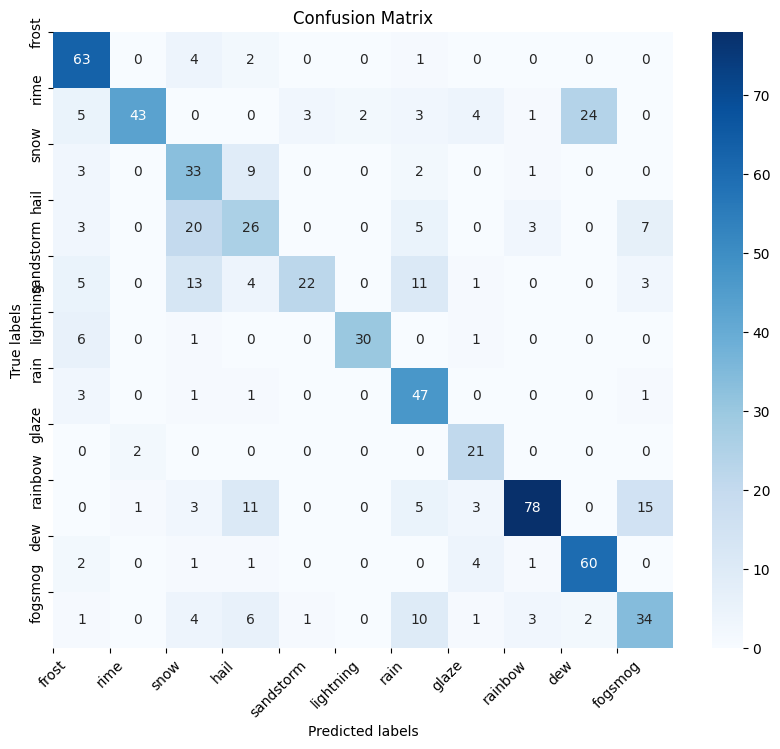

In [20]:
# Create confusion matrix
cm = confusion_matrix(test_generator.labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(No_classes), labels, rotation=45)
plt.yticks(np.arange(No_classes), labels)
plt.show()

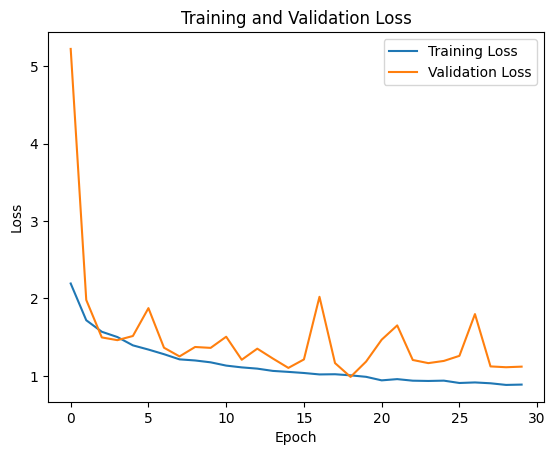

In [21]:
# Plot the loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


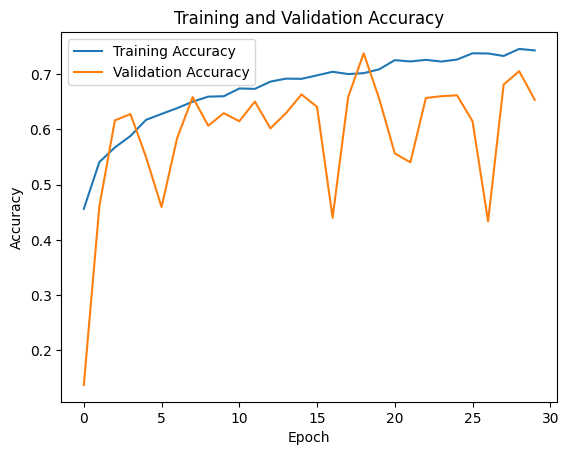

In [22]:
# Plot the accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [23]:
# Define the directory and filename
save_dir = 'Saved Models'
model_name = 'Mini_Project-Arch-1.h5'

# Save the model
model.save(os.path.join(save_dir, model_name))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
